In [177]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder

In [178]:
df = pd.read_csv("../data/Rumah.comdataset_v3.csv")
df = df.drop(columns=['Property Link', 'ID'])
df['Listing Area'] = df['Listing Area'].str.replace(' m²', '')
df = df.astype({'Listing Area':'int64'})
#Print the shape of the dataset before removing outliers
print(df.shape)

(19439, 7)


In [179]:
df.head()

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
0,2.960000e+09,Cempaka Putih,4,3,92,SHM - Sertifikat Hak Milik,CENTRAL
1,4.400000e+08,Salemba,2,2,40,SHM - Sertifikat Hak Milik,CENTRAL
2,2.900000e+09,Cempaka Putih,4,3,92,SHM - Sertifikat Hak Milik,CENTRAL
3,1.061321e+09,Cempaka Putih,2,2,58,SHM - Sertifikat Hak Milik,CENTRAL
4,1.061000e+09,Cempaka Putih,2,2,58,SHM - Sertifikat Hak Milik,CENTRAL


In [180]:
y = df.Price
X = df.drop(['Price'], axis=1)

In [181]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, 
                                                            train_size=0.8, test_size=0.2)

In [182]:
X_concat = pd.concat([X_train_full, y_train], axis=1)
X_concat.shape

(15551, 7)

In [183]:
#Before we start, perform outlier detection and removal (removing all rows with outlier values) for numerical columns
outliers = pd.DataFrame()


numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
#Keep removing outliers until there are no more outliers (run the loop 5 times)
for i in range(10):
    #Check if there are any outliers
    for col in numerical_cols:
        # Perform outlier detection using Interquartile Range
        Q1 = X_concat[col].quantile(0.25)
        Q3 = X_concat[col].quantile(0.75)
        IQR = Q3 - Q1
#         # Before removing outliers, put the outliers in a separate dataframe
#         outliers = outliers.append(df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)])
        # Remove outliers
        X_concat = X_concat[(X_concat[col] >= Q1 - 1.5*IQR) & (X_concat[col] <= Q3 + 1.5*IQR)]



#Print the shape of the dataset after outlier removal
print(X_concat.shape)

(8721, 7)


In [184]:
y_train = X_concat.Price
X_train_full = X_concat.drop(['Price'], axis=1)

In [185]:
# cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
# X_train_full.drop(cols_with_missing, axis=1, inplace=True)
# X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

In [186]:
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]
high_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() >= 10 and 
                        X_train_full[cname].dtype == "object"]
low_cardinality_cols, high_cardinality_cols

(['Jakarta Division'], ['Street Address', 'Certificate'])

In [187]:
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

In [188]:
numerical_cols

['Bed', 'Bath', 'Listing Area']

In [189]:
my_cols = low_cardinality_cols + high_cardinality_cols+ numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [190]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Jakarta Division', 'Street Address', 'Certificate']


In [191]:
# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)
    r2 = r2_score(y_valid, preds)
    #Get the number of samples and features in the validation set
    n_samples, n_features = X_train.shape
    #Calculate the degree of freedoms for residuals
    dof_residuals = n_samples - n_features - 1
    #Calculate the adjusted r2 score
    adj_r2 = 1 - (1 - r2) * (dof_residuals / (n_samples - 1))
    #calculate the root mean squared error
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    mape = mean_absolute_percentage_error(y_valid, preds)
    return mae, rmse, adj_r2, mape, preds


In [192]:
# Function to optimize hyperparameters for Random Forest
#Return the parameters that give the best MAE
def optimize_rf(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(random_state=0)
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = [1.0, 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                     'max_features': max_features,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf,
                        'bootstrap': bootstrap}
    #The target metric is MAE
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring=scorer)
    rf_random.fit(X_train, y_train)
    preds = rf_random.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)
    r2 = r2_score(y_valid, preds)
    #Get the number of samples and features in the validation set
    n_samples, n_features = X_train.shape
    #Calculate the degree of freedoms for residuals
    dof_residuals = n_samples - n_features - 1
    #Calculate the adjusted r2 score
    adj_r2 = 1 - (1 - r2) * (dof_residuals / (n_samples - 1))
    #calculate the root mean squared error
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    return mae, rmse, adj_r2, rf_random.best_params_

In [193]:
# Using approach 1: Drop Categorical Variables
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE, RMSE, Adjusted R2, MPAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE, RMSE, Adjusted R2, MPAE from Approach 1 (Drop categorical variables):
(6511605358.494764, 20026675642.739536, -0.04686998401242404, 2825.3161629081715, array([4.77221924e+09, 5.27284633e+09, 5.02865790e+09, ...,
       4.33534483e+09, 8.45814534e+08, 5.34180000e+09]))


In [194]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])

print("MAE, R2, Adjusted R2, MPAE from Approach 2 (Ordinal Encoding):") 
a = score_dataset(label_X_train, label_X_valid, y_train, y_valid)
print(a)

MAE, R2, Adjusted R2, MPAE from Approach 2 (Ordinal Encoding):
(6431081934.166012, 20099811773.681175, -0.05416722745922531, 2491.7195943336424, array([5.78234286e+09, 4.47928333e+09, 4.24350500e+09, ...,
       3.77783333e+09, 7.67580000e+08, 3.68755723e+09]))


In [195]:
y_valid = y_valid/100000000
pred = pd.Series(a[-1])/100000000
pred.name = "Price_prediction"
total_df = pd.concat([X_valid, y_valid], axis=1)
total_df.reset_index(inplace=True)
total_df = pd.concat([total_df, pred], axis=1)
total_df.drop('index', axis=1, inplace=True)
total_df

,Jakarta Division,Street Address,Certificate,Bed,Bath,Listing Area,Price,Price_prediction
0,NORTH,Kelapa Gading,SHM - Sertifikat Hak Milik,5,3,300,63.00,57.823429
1,WEST,Jelambar,SHM - Sertifikat Hak Milik,4,3,374,56.00,44.792833
2,WEST,Jelambar,SHM - Sertifikat Hak Milik,4,3,306,27.00,42.435050
3,NORTH,Pantai Indah Kapuk,PPJB - Perjanjian Pengikatan Jual Beli,4,4,450,113.50,47.322200
4,EAST,Cakung,SHM - Sertifikat Hak Milik,2,2,57,25.00,20.807722
...,...,...,...,...,...,...,...,...
3883,WEST,Angke,SHM - Sertifikat Hak Milik,3,3,320,35.00,48.175200
3884,CENTRAL,Cempaka Putih,Hak Pakai,1,0,483,0.35,52.941947
3885,EAST,Jakarta Garden City/JGC,PPJB - Perjanjian Pengikatan Jual Beli,4,3,197,40.00,37.778333
3886,WEST,Jelambar,SHGB - Hak Guna Bangunan,2,0,50,6.99,7.675800


In [196]:
error = abs((total_df.Price - total_df.Price_prediction)) / total_df.Price * 100
error.name = "Prediction_Error"
total_df = pd.concat([total_df, error], axis=1)
total_df

,Jakarta Division,Street Address,Certificate,Bed,Bath,Listing Area,Price,Price_prediction,Prediction_Error
0,NORTH,Kelapa Gading,SHM - Sertifikat Hak Milik,5,3,300,63.00,57.823429,8.216780
1,WEST,Jelambar,SHM - Sertifikat Hak Milik,4,3,374,56.00,44.792833,20.012798
2,WEST,Jelambar,SHM - Sertifikat Hak Milik,4,3,306,27.00,42.435050,57.166852
3,NORTH,Pantai Indah Kapuk,PPJB - Perjanjian Pengikatan Jual Beli,4,4,450,113.50,47.322200,58.306432
4,EAST,Cakung,SHM - Sertifikat Hak Milik,2,2,57,25.00,20.807722,16.769112
...,...,...,...,...,...,...,...,...,...
3883,WEST,Angke,SHM - Sertifikat Hak Milik,3,3,320,35.00,48.175200,37.643429
3884,CENTRAL,Cempaka Putih,Hak Pakai,1,0,483,0.35,52.941947,15026.270476
3885,EAST,Jakarta Garden City/JGC,PPJB - Perjanjian Pengikatan Jual Beli,4,3,197,40.00,37.778333,5.554167
3886,WEST,Jelambar,SHGB - Hak Guna Bangunan,2,0,50,6.99,7.675800,9.811159


<AxesSubplot:>

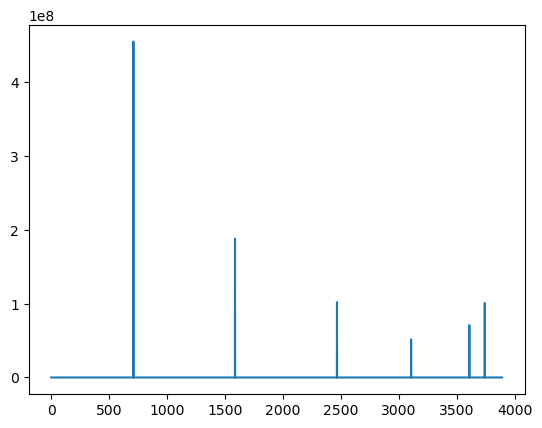

In [197]:
error.plot()

In [198]:
index1 = total_df[total_df.Prediction_Error >= 1000].index
print(index1)

Int64Index([ 105,  124,  605,  709,  727,  872, 1046, 1386, 1504, 1554, 1585,
            1622, 1831, 2207, 2232, 2464, 2486, 2510, 2601, 2804, 2897, 3103,
            3158, 3262, 3372, 3526, 3581, 3605, 3738, 3825, 3884],
           dtype='int64')


In [199]:
#There are houses that's price is too low
total_df.loc[index1]

,Jakarta Division,Street Address,Certificate,Bed,Bath,Listing Area,Price,Price_prediction,Prediction_Error
105,CENTRAL,Menteng,SHM - Sertifikat Hak Milik,5,3,340,0.135000,46.329571,3.421820e+04
124,EAST,Dewi Sartika,SHM - Sertifikat Hak Milik,3,3,95,0.100000,13.769525,1.366952e+04
605,EAST,Jl. Bekasi Raya,SHM - Sertifikat Hak Milik,4,4,125,0.500000,20.989526,4.097905e+03
709,CENTRAL,Sawah Besar,SHM - Sertifikat Hak Milik,3,2,80,0.000003,15.920690,4.548768e+08
727,EAST,Condet,SHM - Sertifikat Hak Milik,2,2,100,0.011500,14.702290,1.277460e+05
872,CENTRAL,Menteng,SHM - Sertifikat Hak Milik,7,5,630,0.500000,43.263167,8.552633e+03
1046,NORTH,Pantai Indah Kapuk,PPJB - Perjanjian Pengikatan Jual Beli,3,3,150,0.680000,33.140540,4.773609e+03
1386,WEST,Jl. Kembangan Raya,SHGB - Hak Guna Bangunan,1,1,300,1.800000,45.342233,2.419013e+03
1504,SOUTH,Jagakarsa,SHM - Sertifikat Hak Milik,3,3,124,0.130000,14.095840,1.074295e+04
1554,NORTH,Pantai Indah Kapuk,Hak Sewa,2,2,45,0.350000,8.616563,2.361875e+03


<AxesSubplot:>

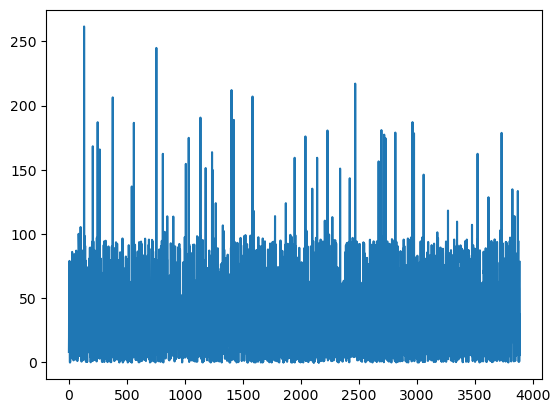

In [200]:
removed_df = total_df.drop(index1)
removed_df.Prediction_Error.plot()

In [201]:
removed_df.shape

(3857, 9)

In [202]:
removed_df.Prediction_Error.mean()

36.96161053866572

In [203]:
total_df.Prediction_Error.mean()

249171.95943336445

In [204]:
total_df.Price_prediction.mean()

35.605111910775975

In [205]:
total_df.Price.mean()

95.79452877531638

In [47]:
# #Using Ordinal Encoding with Hyperparameter Optimization
# print("MAE, R2, Adjusted R2 from Approach 2 (Ordinal Encoding) with Hyperparameter Optimization:")
# print(optimize_rf(label_X_train, label_X_valid, y_train, y_valid))

MAE, R2, Adjusted R2 from Approach 2 (Ordinal Encoding) with Hyperparameter Optimization:
Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [155]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

#To remove warnings
OH_cols_train.columns = OH_cols_train.columns.astype('str')
OH_cols_valid.columns = OH_cols_valid.columns.astype('str')

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print("MAE, MAPE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE, MAPE from Approach 3 (One-Hot Encoding):
(3596273067.020274, 14883594585.238535, 0.42536829292474854, 0.35401412766104645, array([2.95772857e+09, 4.69532055e+08, 2.14971905e+09, ...,
       9.40552500e+09, 1.95375000e+10, 1.61100000e+10]))


In [135]:
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]
high_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() >= 10 and 
                        X_train_full[cname].dtype == "object"]
low_cardinality_cols, high_cardinality_cols

(['Jakarta Division'], ['Street Address', 'Certificate'])

In [136]:
# Make copy to avoid changing original data 
mix_X_train = X_train.copy()
mix_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
mix_X_train[high_cardinality_cols] = ordinal_encoder.fit_transform(X_train[high_cardinality_cols])
mix_X_valid[high_cardinality_cols] = ordinal_encoder.transform(X_valid[high_cardinality_cols])

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(mix_X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(mix_X_valid[low_cardinality_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = mix_X_train.drop(low_cardinality_cols, axis=1)
num_X_valid = mix_X_valid.drop(low_cardinality_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# print("MAE from Approach 4 (Ordinal Encoding + One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

/Users/an-uigeun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


(7968443153.551135, 12576104665.171598, -3859045381628068.5, 0.9999999892552929, array([3.17976167e+10, 3.49732857e+09, 1.12871808e+09, ...,
       3.01468333e+09, 1.68621500e+10, 3.74409167e+09]))


/Users/an-uigeun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
y_valid.mean()

In [ ]:
# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)
    r2 = r2_score(y_valid, preds)
    #Get the number of samples and features in the validation set
    n_samples, n_features = X_train.shape
    #Calculate the degree of freedoms for residuals
    dof_residuals = n_samples - n_features - 1
    #Calculate the adjusted r2 score
    adj_r2 = 1 - (1 - r2) * (dof_residuals / (n_samples - 1))
    return mae, r2, adj_r2

In [ ]:
#Make a dataframe whose columns are before and after encoding
encoder_explanation = pd.DataFrame(columns=['before encoding', 'after encoding'])

#Print the lists for each categorical variable (before and after encoding)
#Put them in three separate columns in a dataframe for easy comparison
#The columns are: before encoding, after encoding
#The rows are categorical variable + value (as "before encoding") and the corresponding encoded value (as "after encoding")
for col in object_cols:
    for i in range(len(X_train[col].unique())):
        encoder_explanation.loc[col + ' ' + str(X_train[col].unique()[i])] = [X_train[col].unique()[i], label_X_train[col].unique()[i]]
        encoder_explanation.loc[col + ' ' + str(X_train[col].unique()[i]), 'before encoding'] = X_train[col].unique()[i]
        encoder_explanation.loc[col + ' ' + str(X_train[col].unique()[i]), 'after encoding'] = label_X_train[col].unique()[i]

encoder_explanation

#Save the encoder_explanation dataframe to a csv file
encoder_explanation.to_csv('ordinal_encoder_explanation.csv')


In [ ]:
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]
high_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() >= 10 and 
                        X_train_full[cname].dtype == "object"]
low_cardinality_cols, high_cardinality_cols

(['Jakarta Division'], ['Street Address', 'Certificate'])

/var/folders/p4/hlsdgszd7ysfnhxp8_f64bhm0000gn/T/ipykernel_71040/346260603.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt='.1g')


<Axes: >

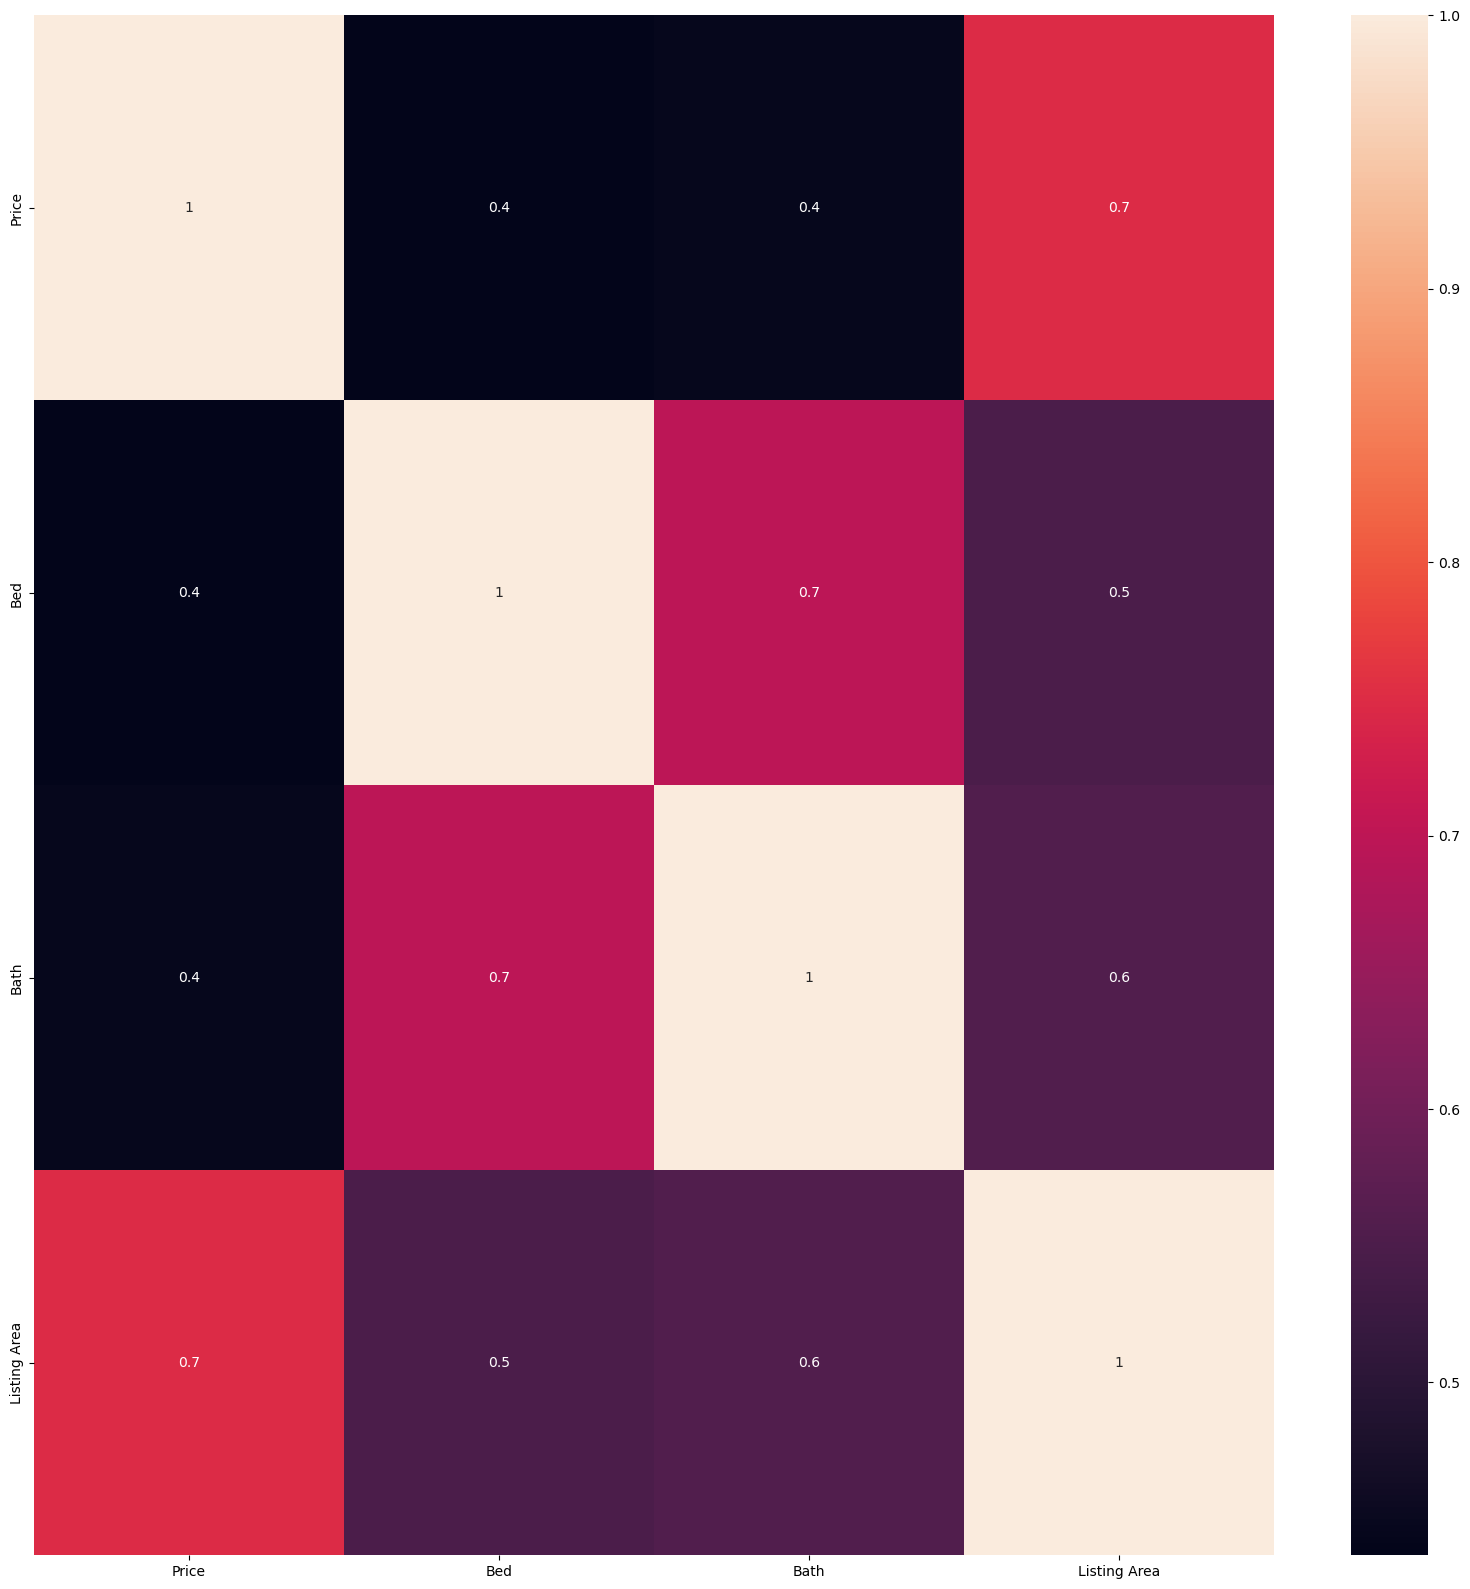

In [ ]:
#Try to visualize the data to see if there is any correlation between the features and the target
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, fmt='.1g')


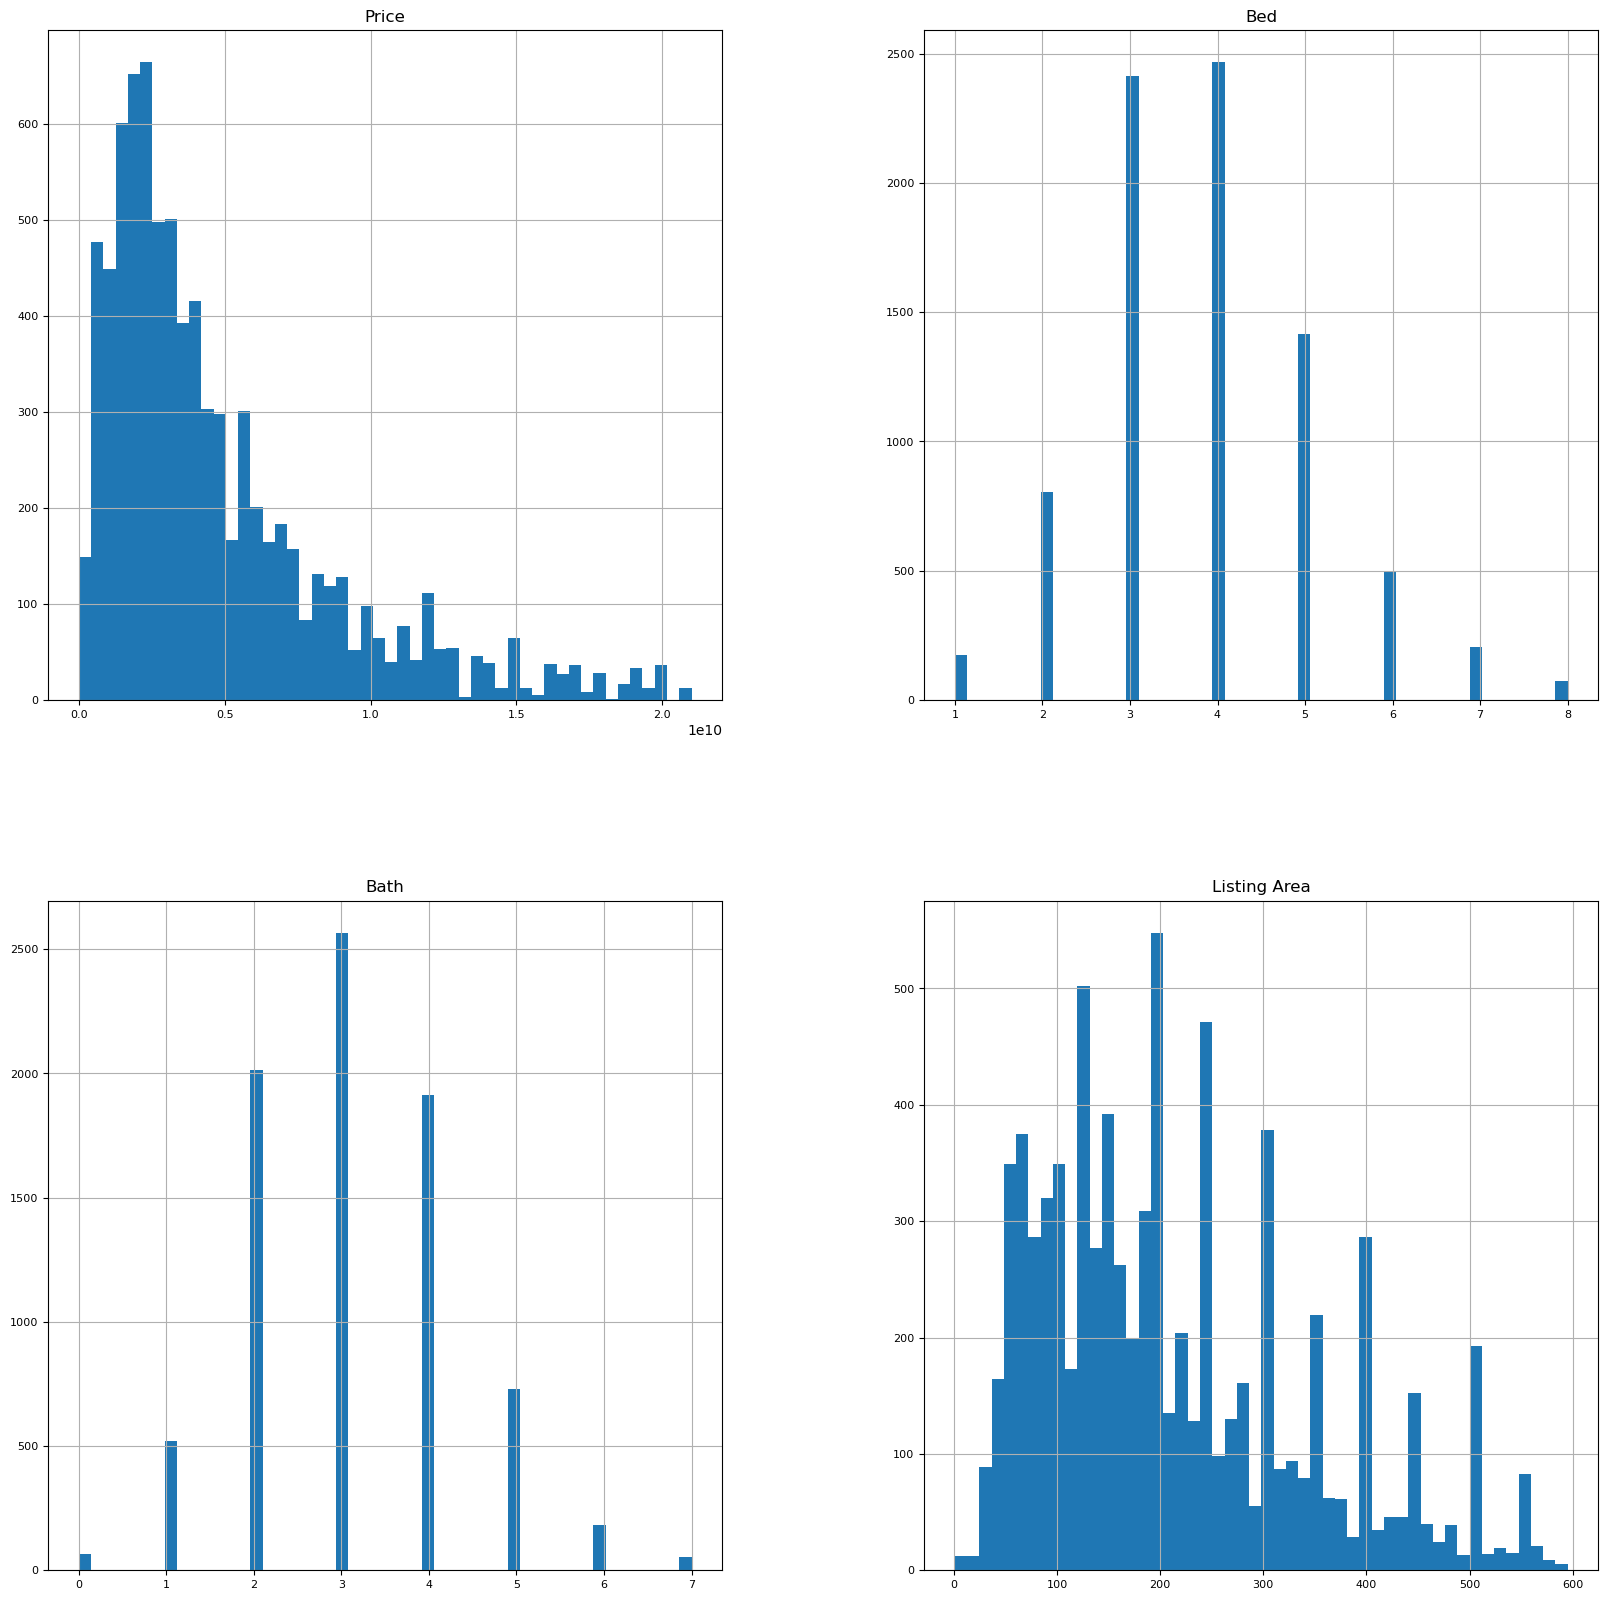

In [ ]:
#Check the histograms of all the features
df.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations


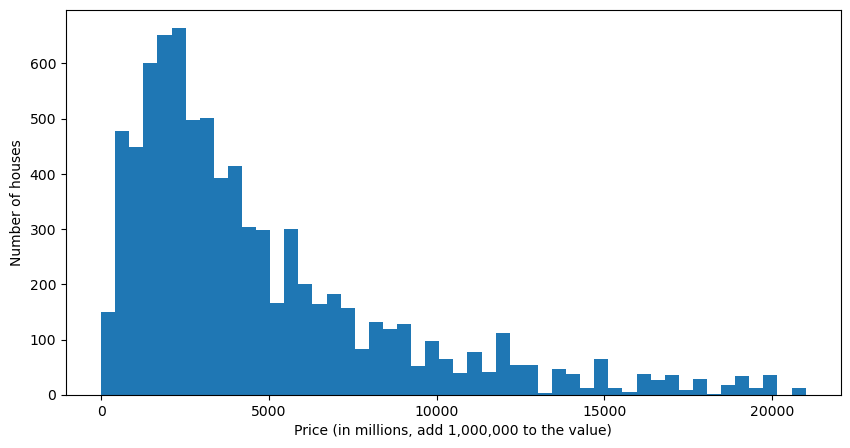

In [ ]:
#Specifically make a histogram only for price, but this time write the full scale of the x value (in millions)
plt.figure(figsize=(10, 5))
#Divide the price by 1,000,000 and add the text "M" to the x label
plt.hist(df['Price']/1000000, bins=50)
plt.xlabel('Price (in millions, add 1,000,000 to the value)')
plt.ylabel('Number of houses')
plt.show()

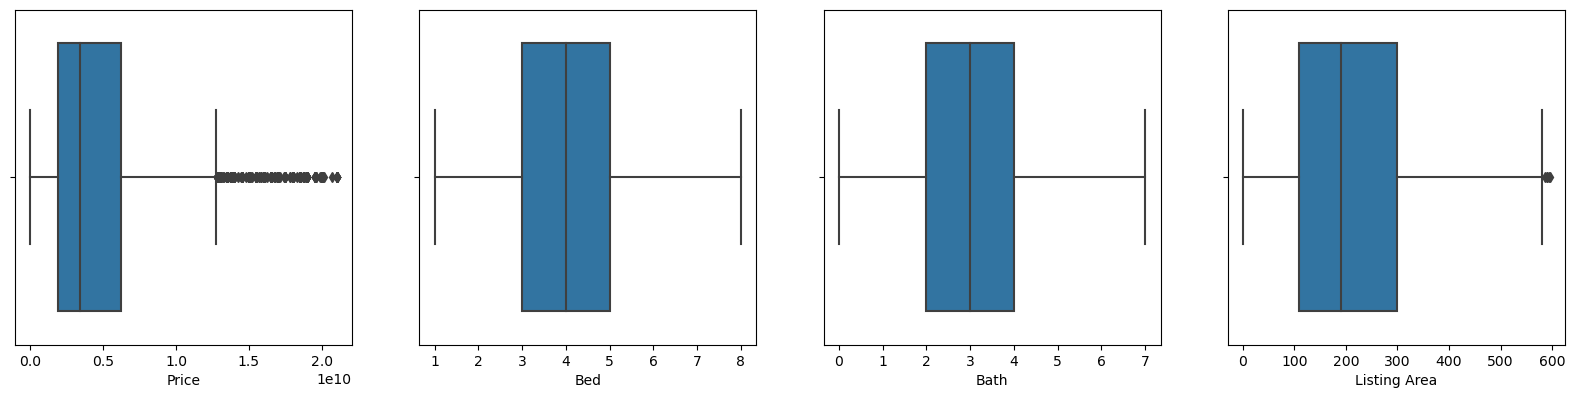

In [ ]:
#Perform outlier detection by plotting boxplots for the numerical features
plt.figure(figsize=(20, 20))
#Get all columns with numerical data from df
numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
#Plot boxplots for all numerical columns
for i in range(len(numerical_cols)):
    plt.subplot(4, 4, i+1)
    sns.boxplot(x=df[numerical_cols[i]])


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH


In [ ]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
5297,21000000000,Pondok Indah,5,5,545,SHM - Sertifikat Hak Milik,SOUTH
5312,21000000000,Pondok Indah,5,4,500,SHM - Sertifikat Hak Milik,SOUTH
9609,21000000000,Pluit,2,2,350,SHM - Sertifikat Hak Milik,NORTH
934,21000000000,Menteng,4,4,370,SHM - Sertifikat Hak Milik,CENTRAL
5747,21000000000,Kebayoran Baru,7,4,500,SHM - Sertifikat Hak Milik,SOUTH
4967,21000000000,Cipete,7,5,360,SHM - Sertifikat Hak Milik,SOUTH
5547,21000000000,Kebayoran Lama,2,3,236,SHM - Sertifikat Hak Milik,SOUTH
8662,21000000000,Pantai Indah Kapuk,4,4,446,SHGB - Hak Guna Bangunan,NORTH
9592,21000000000,Pantai Indah Kapuk,7,7,486,SHM - Sertifikat Hak Milik,NORTH
5352,21000000000,Panglima Polim,7,7,386,SHM - Sertifikat Hak Milik,SOUTH
